In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
df = pd.read_csv('../Data_Files/Bushtucker.dat',sep='\t')
df

,participant,stick_insect,kangaroo_testicle,fish_eye,witchetty_grub
0,P1,8,7,1,6
1,P2,9,5,2,5
2,P3,6,2,3,8
3,P4,5,3,1,9
4,P5,8,4,5,8
5,P6,7,5,6,7
6,P7,10,2,7,2
7,P8,12,6,8,1


### Converting data from wide to Long format

In [3]:
df_long = pd.melt(df, id_vars=['participant'], value_vars=['stick_insect','kangaroo_testicle','fish_eye','witchetty_grub'])
df_long.sort_values(['participant','variable'],inplace=True)
df_long.reset_index(drop=True, inplace=True)
df_long.head(8)

,participant,variable,value
0,P1,fish_eye,1
1,P1,kangaroo_testicle,7
2,P1,stick_insect,8
3,P1,witchetty_grub,6
4,P2,fish_eye,2
5,P2,kangaroo_testicle,5
6,P2,stick_insect,9
7,P2,witchetty_grub,5


### Analyzing the Data

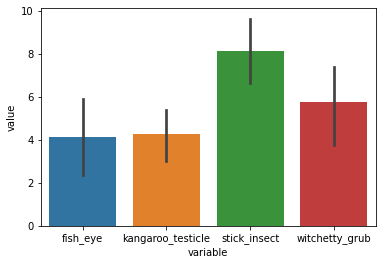

In [4]:
_ = sns.barplot(x='variable', y='value',data=df_long)

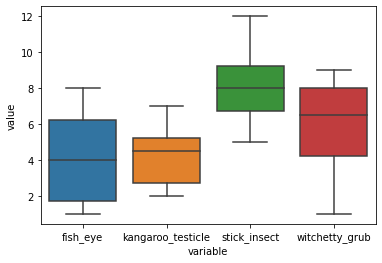

In [5]:
_ = sns.boxplot(x='variable', y='value',data=df_long)

In [6]:
df_long.groupby('variable').describe()['value']

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
fish_eye,8.0,4.125,2.748376,1.0,1.75,4.0,6.25,8.0
kangaroo_testicle,8.0,4.250,1.832251,2.0,2.75,4.5,5.25,7.0
stick_insect,8.0,8.125,2.232071,5.0,6.75,8.0,9.25,12.0
witchetty_grub,8.0,5.750,2.915476,1.0,4.25,6.5,8.00,9.0


## Repeating measure anova using python

In [7]:
import statsmodels.stats.anova as sp

In [10]:
aovrm = sp.AnovaRM(df_long, 'value', 'participant', within=['variable']).fit()
aovrm.summary()

,F Value,Num DF,Den DF,Pr > F
variable,3.7938,3.0000,21.0000,0.0256


####  Calculation of between-subject effects and corrections for violation of sphericity are not yet implemented when you use statsmodels AnovaRM 

In [18]:
pg.rm_anova(df_long,within=['variable'],subject='participant',dv='value',effsize='n2')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,n2,eps,sphericity,W-spher,p-spher
0,variable,3,21,3.793806,0.02557,0.062584,0.35148,0.532846,False,0.136248,0.046846


#### The upper implementation of repeated measure anova in python using pingouin module gives the corrections for violation of sphericity . 

##### see https://pingouin-stats.org/generated/pingouin.rm_anova.html

### As per  Greenhouse–Geisser correction ,  the F-ratio is non-significant(although mind that this correction is somewhat conservative) .

## Using multilevel approach, you can forget about sphericity

In [53]:
mlm_mod_baseline = smf.mixedlm(
    formula = 'value ~ 1', 
    groups = 'participant', 
    data=df_long
)

# Run the fit
mlm_result_baseline = mlm_mod_baseline.fit(reml=False)

# Print out the summary of the fit
mlm_result_baseline.summary()

/home/atrides/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/atrides/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/atrides/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/atrides/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM  Dependent Variable:  value   
No. Observations:  32       Method:              ML      
No. Groups:        8        Scale:               7.9336  
Min. group size:   4        Log-Likelihood:      -78.5437
Max. group size:   4        Converged:           Yes     
Mean group size:   4.0                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       5.563    0.498 11.171 0.000  4.587  6.538
participant Var 0.000                                    
=========================================================

"""

In [54]:
mlm_mod = smf.mixedlm(
    formula = 'value ~ C(variable)', 
    groups ='participant', 
    data=df_long
)
# Run the fit
mlm_result = mlm_mod.fit(reml = False)   # we are using method maximum likelihood instead of restricted maximum  likelihood
# Print out the summary of the fit
mlm_result.summary()

/home/atrides/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/atrides/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       value   
No. Observations:        32            Method:                   ML      
No. Groups:              8             Scale:                    5.3359  
Min. group size:         4             Log-Likelihood:           -72.1975
Max. group size:         4             Converged:                Yes     
Mean group size:         4.0                                             
-------------------------------------------------------------------------
                                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                        4.125    0.817 5.051 0.000  2.524  5.726
C(variable)[T.kangaroo_testicle] 0.125    1.155 0.108 0.914 -2.139  2.389
C(variable)[T.stick_insect]      4.000    1.155 3.463 0.001  1.736  6.264
C(variable)[T.witchetty_grub]    1.625    1.155 1.407 0.159 -0.639  3.889
participant Var                  0.000                                   
=========================================================================

"""

In [65]:
chiSquare_ratio = (-2*mlm_result_baseline.llf-(-2*mlm_result.llf))
chiSquare_ratio

12.69252869295093

In [66]:
print('aic: ',mlm_result.aic,'\t','bic: ',mlm_result.bic,'\t','log likelihood: ',mlm_result.llf)

aic:  156.39493318781382 	 bic:  165.18934860461218 	 log likelihood:  -72.19746659390691


In [67]:
print('aic: ',mlm_result_baseline.aic, '\t','bic: ',mlm_result_baseline.bic,'\t','log likelihood: ',mlm_result_baseline.llf)

aic:  163.08746188076475 	 bic:  167.48466958916393 	 log likelihood:  -78.54373094038237


In [68]:
chi_df = 3

In [70]:
chi_square_pvalue = 1 - st.chi2.cdf(12.692,chi_df)
print('chisquare_Stats: ',chiSquare_ratio,'\t', 'p_value',chi_square_pvalue)

chisquare_Stats:  12.69252869295093 	 p_value 0.00535230533784814


#### # from p-value and L.Ratio, we can see that after including Animal in our independent variable , there is improvement in model correctness.

## Post-Hoc tests

In [71]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

In [72]:
multicomp = MultiComparison(df_long['value'], df_long['variable'])   # testfunc

In [73]:
# Bonferroni
com = multicomp.allpairtest(st.ttest_rel, method='bonf')
print(com[0])

Test Multiple Comparison ttest_rel 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
      group1            group2        stat   pval  pval_corr reject
-------------------------------------------------------------------
         fish_eye kangaroo_testicle  -0.104 0.9201       1.0  False
         fish_eye      stick_insect  -5.465 0.0009    0.0056   True
         fish_eye    witchetty_grub -0.8919  0.402       1.0  False
kangaroo_testicle      stick_insect -4.7753  0.002    0.0121   True
kangaroo_testicle    witchetty_grub -1.1225 0.2987       1.0  False
     stick_insect    witchetty_grub  1.3252 0.2267       1.0  False
-------------------------------------------------------------------


In [74]:
# Tukey HSD
co = multicomp.tukeyhsd(alpha=0.05)
co.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
fish_eye,kangaroo_testicle,0.125,0.9,-3.2462,3.4962,False
fish_eye,stick_insect,4.0,0.0154,0.6288,7.3712,True
fish_eye,witchetty_grub,1.625,0.555,-1.7462,4.9962,False
kangaroo_testicle,stick_insect,3.875,0.0196,0.5038,7.2462,True
kangaroo_testicle,witchetty_grub,1.5,0.6107,-1.8712,4.8712,False
stick_insect,witchetty_grub,-2.375,0.2414,-5.7462,0.9962,False


## Effect Size

### see generalized eta-squared which is the output of pingouin rm_anova() under column labelled n2 

## calculating various sum of square

In [75]:
df_long['value'].describe()

count    32.000000
mean      5.562500
std       2.861733
min       1.000000
25%       3.000000
50%       6.000000
75%       8.000000
max      12.000000
Name: value, dtype: float64

In [76]:
SSt = df_long['value'].std()**2 * (32-1)
SSt

253.875

In [77]:
SSt_df = df_long['value'].count()-1
SSt_df

31

In [79]:
std = list(df_long.groupby('participant').describe()['value']['std'])
std

[3.1091263510296048,
 2.8722813232690143,
 2.753785273643051,
 3.415650255319866,
 2.0615528128088303,
 0.9574271077563381,
 3.947573094109004,
 4.573474244670748]

In [80]:
SSw = 0
for i in range(8):
  SSw += std[i]**2 * (4-1)

SSw

236.5

In [81]:
SSw_df = (4-1)*8
SSw_df

24

In [82]:
mean = list(df_long.groupby('variable').describe()['value']['mean'])
mean

[4.125, 4.25, 8.125, 5.75]

In [84]:
SSm = 0
for i in range(4):
  SSm += (8)*(df_long['value'].mean()-mean[i])**2

SSm

83.125

In [87]:
SSm_df = 4-1     # k-1
SSm_df

3

In [88]:
SSr = SSw-SSm
SSr

153.375

In [89]:
SSr_df = SSw_df-SSm_df
SSr_df

21

In [90]:
SSb = SSt-SSw
SSb

17.375

In [91]:
MSm = SSm/SSm_df
MSm

27.708333333333332

In [92]:
MSr = SSr/SSr_df
MSr

7.303571428571429

In [93]:
F = MSm/MSr
F

3.793806030969845